In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Các hàm

def preprocess_contour(img):
    """Xử lý ảnh để detect contour các anchor points."""
    img = cv.medianBlur(img,3)
    img = cv.GaussianBlur(img,(5,5),0)
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 51, 5)
    return img

def preprocess_detect(img):
    """Xử lý ảnh để detect trắc nghiệm."""
    img = cv.GaussianBlur(img, (5, 5), 0)
    img = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY_INV, 51, 5)
    return img

def preprocess_edge(img):
    """Xử lý ảnh để lấy edge."""
    img = cv.GaussianBlur(img,(5,5),0)
    img = cv.Canny(img, threshold1=20, threshold2=100)
    return img

def four_point_transform(image, pts):
    """
        Hàm warp ảnh dùng 4 điểm.

        image: Ảnh ban đầu.
        pts: Array/List 2D gồm bốn điểm, mỗi điểm hai tọa độ [x,y].
    """
    rect = np.zeros((4, 2), dtype = "float32")
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def two_point_transform(image, pts, width):
    """
        Hàm warp ảnh dùng 2 điểm và chiều ngang tùy chọn.

        image: Ảnh ban đầu.
        pts: Array/List 2D gồm hai điểm, mỗi điểm hai tọa độ [x,y].
        width: Chiều ngang tùy chọn.
    """
    rect = np.zeros((4, 2), dtype = "float32")
    if pts[1][1] > pts[0][1]:
        rect[0] = pts[0] # top-left
        rect[3] = pts[1] # bottom-left
    else:
        rect[0] = pts[1] # top-left
        rect[3] = pts[0] # bottom-left
    rect[1] = rect[0] + [width, 0] # top-right
    rect[2] = rect[3] + [width, 0] # bottom-right
    (tl, tr, br, bl) = rect
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    M = cv.getPerspectiveTransform(rect, dst)
    warped = cv.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def get_contours_rect(img, min_width=10,max_width=100, min_height=10,max_height=100, min_white_pixels=200):
    """
        Hàm detect contour (viền) hình vuông.
        Return các contour đc sắp xếp theo thứ tự diện tích từ lớn đến bé.

        img: Ảnh đầu vào.
        min_width, max_width, min_height, max_height: Chiều dài rộng tối thiểu và tối đa để thuật toán dectect.
        min_white_pixels: Số điểm pixel màu trắng tối thiểu cần có trong hình vuông.
    """
    ct = cv.findContours(img, cv.RETR_TREE,cv.CHAIN_APPROX_NONE)
    contours, hierarchy = ct
    rectangles = []
    for contour in contours:
        epsilon = 0.03 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            x, y, w, h = cv.boundingRect(contour)
            aspect_ratio = float(w) / h
            if (aspect_ratio >= 0.7 and aspect_ratio <= 1.2 and
               w >= min_width and w <= max_width and
               h >= min_height and h <= max_height):
                roi = img[y:y+h, x:x+w]
                white_pixel_count = np.sum(roi > 100)
                if white_pixel_count >= min_white_pixels:
                    rectangles.append(contour)
    rectangle_areas = [(rect, cv.contourArea(rect)) for rect in rectangles]
    sorted_rectangle_areas = sorted(rectangle_areas, key=lambda x: x[1], reverse=True)
    rectangles = [rect_area[0] for rect_area in sorted_rectangle_areas]

    return rectangles

def get_contours_circle(img, min_radius = 12, max_radius = 20, min_white_pixels = None):
    """
        Hàm detect contour (viền) hình tròn.
        Return các contour đc sắp xếp theo thứ tự diện tích từ lớn đến bé.

        img: Ảnh đầu vào.
        min_radius: Bán kính tối thiểu để thuật toán dectect.
        max_radius: Bán kính tối đa để thuật toán dectect.
    """
    ct = cv.findContours(img, cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    contours, hierarchy = ct
    circles = []
    for contour in contours:
        epsilon = 0.03 * cv.arcLength(contour, True)
        approx = cv.approxPolyDP(contour, epsilon, True)
        if len(approx) >= 8:
            (x, y), radius = cv.minEnclosingCircle(contour)
            center = (int(round(x)), int(round(y)))
            radius = int(radius)
            if radius >= min_radius and radius <= max_radius:
                if min_white_pixels != None:
                    roi = img[int(round(y-radius)):int(round(y+radius)),int(round(x-radius)):int(round(x+radius))]
                    white_pixel_count = np.sum(roi > 100)
                    if white_pixel_count >= min_white_pixels:
                        circles.append((center, radius))
                else: circles.append((center, radius))
    circle_areas = [(circle, np.pi*radius**2) for circle, radius in circles]
    sorted_circle_areas = sorted(circle_areas, key=lambda x: x[1], reverse=True)
    circles = [circle_area[0] for circle_area in sorted_circle_areas]
    circles_array = np.unique(np.asarray(list(map(list, circles))),axis=0)
    return circles_array

def get_anchor(contour, num_anchors = 4):
    """
        Hàm tính trung bình các tọa độ viền.
        Trả về các điểm anchor cần thiết để warp ảnh.

        contour: Tọa độ viền đã dectect.
        num_anchors: Số điểm anchor. Phải bằng số hình vuông/tròn có trong contour.
    """
    anchor_x = []
    anchor_y = []
    for i in range(len(contour)):
        x = int(round(np.mean(contour[i][:, :, 0])))
        y = int(round(np.mean(contour[i][:, :, 1])))
        anchor_x.append(x)
        anchor_y.append(y)
    temp_anchors, idx = np.unique(np.column_stack((anchor_x,anchor_y)),axis=0,return_index=True)
    anchors = temp_anchors[np.argsort(idx)]
    return anchors[:num_anchors]

def group_avg_values(sorted_array, offset=15):
    """
        Hàm dùng để fix trường hợp không thể detect tất cả các contour hình tròn hoặc detect trùng tọa độ trong sheet đáp án/sbd/mã đề.

        sorted_array: Array/List 1D đã sort của x hoặc y.
        offset: Chênh lệch tối đa giữa các điểm để được tính vào làm một nhóm.
    """
    groups = []
    current_group = [sorted_array[0]]
    for i in range(1, len(sorted_array)):
        if abs(sorted_array[i] - current_group[-1]) <= offset:
            current_group.append(sorted_array[i])
        else:
            groups.append(int(round(sum(current_group)/len(current_group))))
            #groups.append(current_group)
            current_group = [sorted_array[i]]
    groups.append(int(round(sum(current_group)/len(current_group))))
    return groups

def matrix2ans(np_matrix, threshold=20000, start_index=1):
    """
        Hàm chuyển đổi từ ma trận sang kết quả ABCD.

        np_matrix: Ma trận 2D numpy.
        threshold: Độ sáng tối thiểu để được tính kết quả.
        start_index: Vị trí câu bắt đầu.
    """
    ans = {}
    for row in range(np_matrix.shape[0]):
        temp = []
        for col in range(np_matrix.shape[1]):
            if np_matrix[row][col] > threshold:
                temp.append(col)
        ans.update({row+start_index:",".join([decode(num) for num in temp])})
    return ans

def get_correct_ans(user_answers, test_answers):
    """
        Tính kết quả đúng.
        Trả về dictionary {vị trí câu: kết quả}.

        user_answers: Câu trả lời cần kiểm tra.
        test_answers: Câu trả lời đúng.
    """
    correct_answers = {k: test_answers[k] for k in test_answers if k in user_answers and test_answers[k] == user_answers[k]}
    return correct_answers

def decode(num):
    if num == 0: return 'A'
    elif num == 1: return 'B'
    elif num == 2: return 'C'
    elif num == 3: return 'D'
    else: return 'NAN'

# Utility functions

def imshowRGB(img_matrix,big=False):
    if big==True: plt.figure(figsize=(15,10))
    plt.axis('off')
    return plt.imshow(cv.cvtColor(img_matrix,cv.COLOR_BGR2RGB))

In [4]:
width, height = 1240, 1754 #fix định dạng ảnh thành 150PPI A4
de = cv.imread('./test_img_test_csv/106.jpg', cv.IMREAD_GRAYSCALE)
de = cv.resize(de, (width, height))
de_origin = de.copy()
de_pre = preprocess_contour(de.copy())

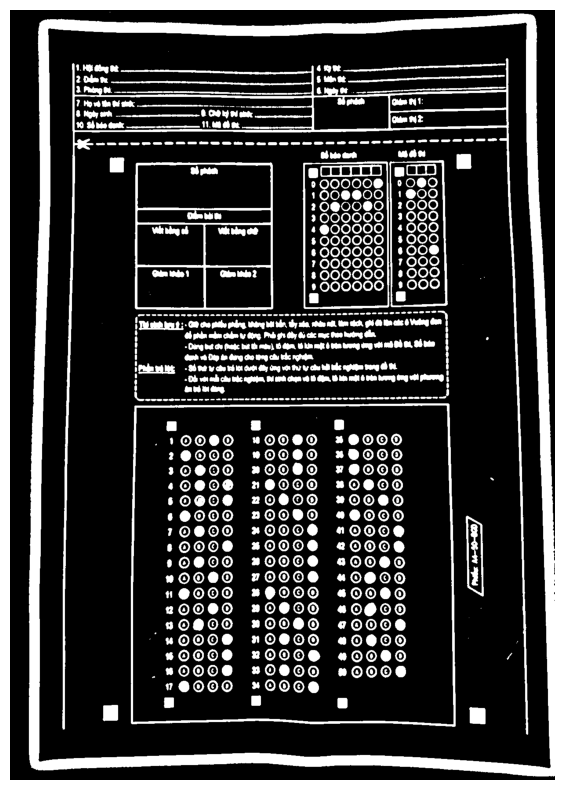

In [5]:
imshowRGB(preprocess_contour(de.copy()),big=True)

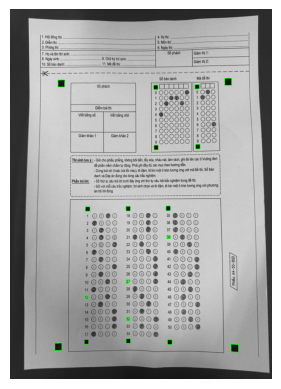

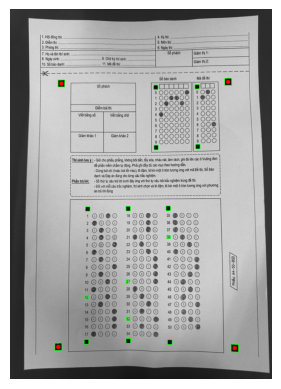

In [6]:
#detect contours của 12 anchors
de_color = cv.cvtColor(de_origin.copy(),cv.COLOR_GRAY2BGR)
rectangles = get_contours_rect(de_pre)
de_color= cv.drawContours(de_color, rectangles, -1, (0, 255, 0), 2)
imshowRGB(de_color)
plt.show()
#Lấy 4 anchor points để chuẩn bị warp
warp_anchor_de = get_anchor(rectangles, num_anchors = 4)
for x,y in warp_anchor_de:
    de_color = cv.circle(de_color, (x,y), radius=10, color=(0, 0, 255), thickness=-1)
imshowRGB(de_color)
plt.show()

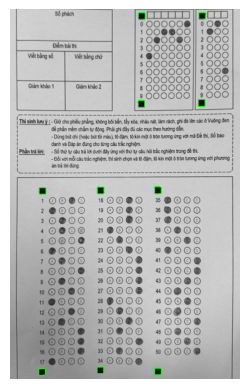

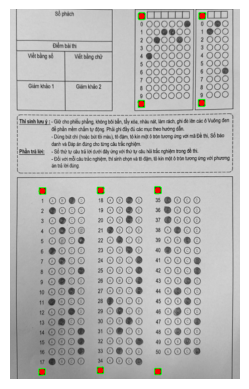

In [7]:
#Warp vào 4 anchor points
center = np.mean(warp_anchor_de, axis=0)
for i in range(len(warp_anchor_de)): # Cắt bớt phần dư
    if warp_anchor_de[i][0] <= center[0]:
        warp_anchor_de[i][0] += 25
    else:
        warp_anchor_de[i][0] -= 25
de_warp = four_point_transform(de_origin.copy(),warp_anchor_de)
de_pre_warp = four_point_transform(de_pre.copy(),warp_anchor_de)

small_rectangles = get_contours_rect(de_pre_warp, min_width=20, min_height=20, min_white_pixels=400)
de_warp_color = cv.cvtColor(de_warp,cv.COLOR_GRAY2BGR)
de_warp_color = cv.drawContours(de_warp_color, small_rectangles, -1, (0, 255, 0), 2)

imshowRGB(de_warp_color)
plt.show()
#Lấy tiếp các anchor points ở sbd, mã đề và trắc nghiệm để warp
warp_anchor_in = get_anchor(small_rectangles, len(small_rectangles))
if len(warp_anchor_in)==0 | len(warp_anchor_in)<8:
    raise Exception("Vui lòng chụp lại ảnh!")
for x,y in warp_anchor_in:
    de_warp_color = cv.circle(de_warp_color, (x,y), radius=10, color=(0, 0, 255), thickness=-1)
imshowRGB(de_warp_color)
plt.show()

In [8]:
width = de_warp_color.shape[1]
height = de_warp_color.shape[0]
upper_anchor = []
lower_anchor = []
warp_anchor_in = warp_anchor_in[np.argsort(warp_anchor_in[:,:1].reshape(-1), axis=0)] #sort theo x
for pts in warp_anchor_in:
    if pts[1] < height*(1/3): # phân ra anchor nửa trên (cho mã đề, số báo danh) và nửa dưới (cho trắc nghiệm)
        upper_anchor.append(pts)
    else:
        lower_anchor.append(pts)
upper_anchor = np.asarray(upper_anchor).reshape(-1,2,2) #reshape (group, 2 pairs, 2 values xy)
lower_anchor = np.asarray(lower_anchor).reshape(-1,2,2)
if len(upper_anchor[0])%2 != 0 | len(upper_anchor[0]) == 0 | len(lower_anchor[0]) == 0:
    raise Exception("Vui lòng chụp lại ảnh!")

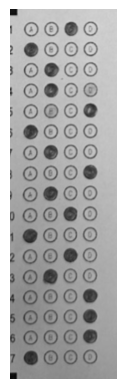

In [9]:
answers = []
sorted_lower_anchor = np.array([sorted(group, key=lambda x: x[1]) for group in lower_anchor])
distance = np.abs(np.diff(sorted_lower_anchor[:,:1,:1], axis=0))
avg_distance = int(round(np.mean(distance)))
offset=20
for i in range(len(lower_anchor)):
    answers.append(two_point_transform(de_warp,lower_anchor[i], width=avg_distance-offset))
imshowRGB(answers[0])

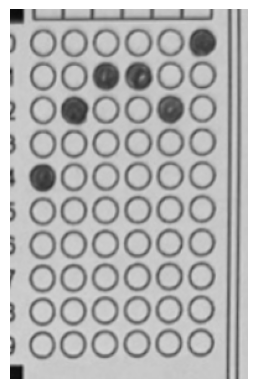

In [10]:
info = []

if len(upper_anchor) == 2:
    sorted_upper_anchor = np.array([sorted(group, key=lambda x: x[1]) for group in upper_anchor])
    distance = np.abs(np.diff(sorted_upper_anchor[:,:1,:1], axis=0))
    avg_distance = int(round(np.mean(distance)))
    offset=15
    info.append(two_point_transform(de_warp,upper_anchor[0], width=avg_distance-offset))
    info.append(two_point_transform(de_warp,upper_anchor[1], width=(avg_distance/2)))
elif len(upper_anchor) == 1:
    info.append(two_point_transform(de_warp,upper_anchor[0], width=150))
imshowRGB(info[0])

In [11]:
def __get_info(img_info):
        """
            Lấy thông tin người làm bài.
        """
        student_info = []
        threshold = 20000
        for i in range(len(img_info)):
            img = preprocess_edge(img_info[i])
            img_detect = preprocess_detect(img_info[i])
            circles = get_contours_circle(img)

            # Fix undetected circles
            x_sorted = np.sort(circles[:,:1].reshape(-1)) # sort x
            y_sorted = np.sort(circles[:,1:2].reshape(-1)) # sort y
            x_group = group_avg_values(x_sorted, offset=10)
            y_group = group_avg_values(y_sorted, offset=10)

            # for circle in circles:
            #     test_img = cv.circle(img_info[0], circle, radius=10, color=(0, 0, 255), thickness=2)
            # imshowRGB(test_img)
            for x in x_group:
                for y in y_group:
                    test_img = cv.circle(img_info[0], [x,y], radius=10, color=(0, 0, 255), thickness=-1)
            imshowRGB(test_img)
            print(y_sorted)
            print(y_group)

            white_pixel_counts = []
            min_white_pixels = 100
            radius = 15
            rows = len(y_group)
            cols = len(x_group)

            for y in y_group:
                for x in x_group:
                    center = (x,y)
                    roi = img_detect[center[1]-radius:center[1]+radius, center[0]-radius:center[0]+radius]
                    # Count the white pixels in the roi
                    count = np.sum(roi)
                    white_pixel_counts.append(count)

            white_pixel_counts = np.asarray(white_pixel_counts).reshape((rows,cols))
            white_pixel_counts = white_pixel_counts-(np.average(white_pixel_counts)*0.8)
            if True:
                return white_pixel_counts
            if white_pixel_counts.shape[1] == 3 and sum(sum(white_pixel_counts>threshold)) != 3:
                raise Exception("Mã đề không hợp lệ!")
            if white_pixel_counts.shape[1] == 6 and sum(sum(white_pixel_counts>threshold)) != 6:
                raise Exception("Số báo danh không hợp lệ!")

            detected_info = "".join(map(str,np.argmax(white_pixel_counts, axis=0)))
            student_info.append(detected_info)
        return white_pixel_counts

[ 26  27  27  27  27  27  53  54  54  54  80  81  81  81  82 107 107 108
 108 108 108 109 109 134 134 134 135 135 136 161 162 162 162 163 163 188
 188 189 189 190 190 190 216 216 216 216 217 217 242 242 243 243 244 244
 269 270 270 271]
[27, 54, 81, 108, 135, 162, 189, 216, 243, 270]


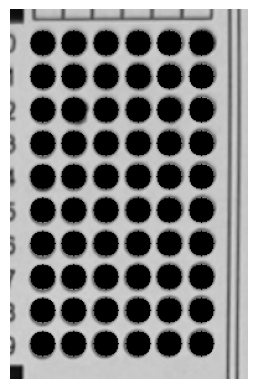

In [12]:
white = __get_info(info)

Test for answer0

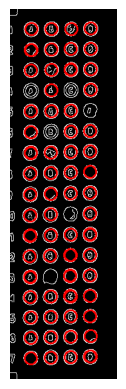

In [13]:
test_img = preprocess_edge(answers[0])
test_detect = preprocess_detect(answers[0])

circles = get_contours_circle(test_img)
test_img = cv.cvtColor(test_img,cv.COLOR_GRAY2BGR)

for circle in circles:
    test_img = cv.circle(test_img, circle, radius=10, color=(0, 0, 255), thickness=2)
imshowRGB(test_img)

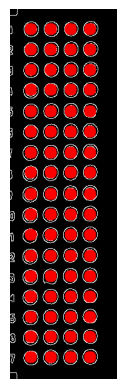

In [14]:
# Fix undetected circles
x_sorted = np.sort(circles[:,:1].reshape(-1)) # sort x
y_sorted = np.sort(circles[:,1:2].reshape(-1)) # sort y
x_group = group_avg_values(x_sorted, offset=15)
y_group = group_avg_values(y_sorted, offset=15)

test_img = preprocess_edge(answers[0])
test_img = cv.cvtColor(test_img,cv.COLOR_GRAY2BGR)
for x in x_group:
    for y in y_group:
        test_img = cv.circle(test_img, [x,y], radius=10, color=(0, 0, 255), thickness=-1)
imshowRGB(test_img)

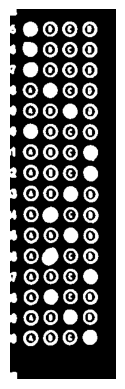

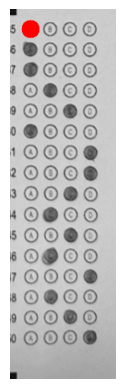

white_pixel_count 128775
--------------------------------------------------


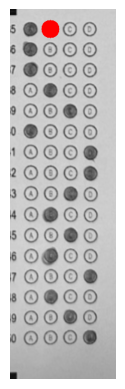

white_pixel_count 91545
--------------------------------------------------


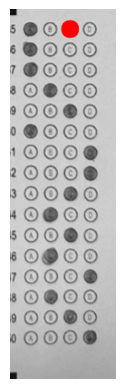

white_pixel_count 96135
--------------------------------------------------


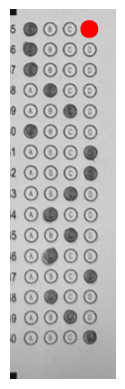

white_pixel_count 100215
--------------------------------------------------


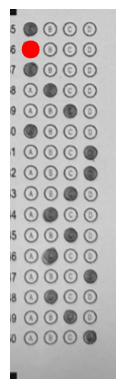

white_pixel_count 130050
--------------------------------------------------


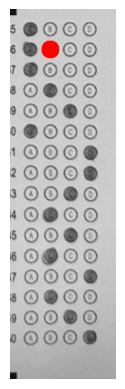

white_pixel_count 90525
--------------------------------------------------


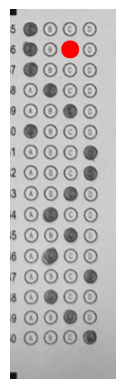

white_pixel_count 92055
--------------------------------------------------


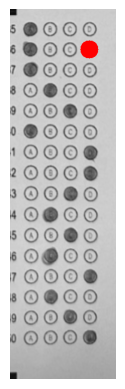

white_pixel_count 98175
--------------------------------------------------


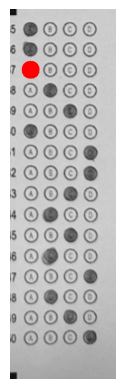

white_pixel_count 130560
--------------------------------------------------


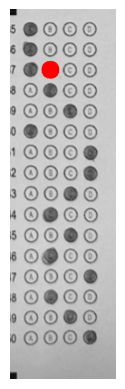

white_pixel_count 84915
--------------------------------------------------


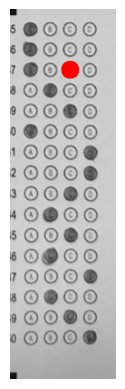

white_pixel_count 93330
--------------------------------------------------


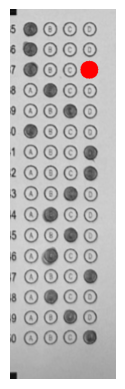

white_pixel_count 97410
--------------------------------------------------


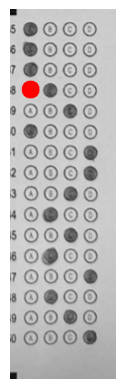

white_pixel_count 87210
--------------------------------------------------


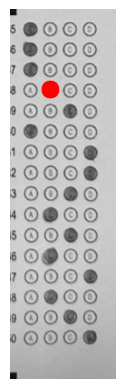

white_pixel_count 125970
--------------------------------------------------


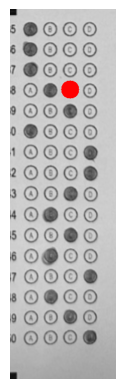

white_pixel_count 88740
--------------------------------------------------


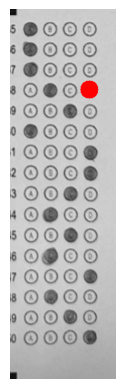

white_pixel_count 96135
--------------------------------------------------


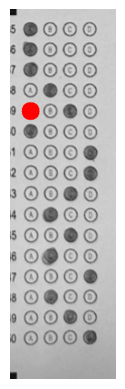

white_pixel_count 88485
--------------------------------------------------


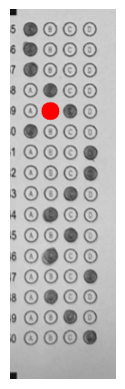

white_pixel_count 87465
--------------------------------------------------


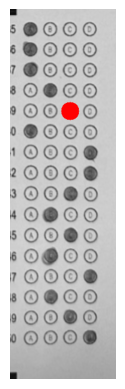

white_pixel_count 127245
--------------------------------------------------


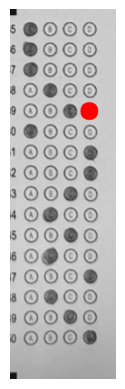

white_pixel_count 98175
--------------------------------------------------


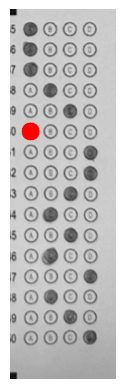

white_pixel_count 128520
--------------------------------------------------


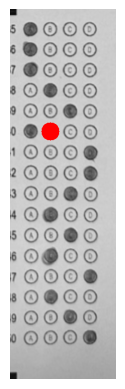

white_pixel_count 92820
--------------------------------------------------


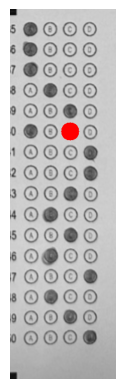

white_pixel_count 88740
--------------------------------------------------


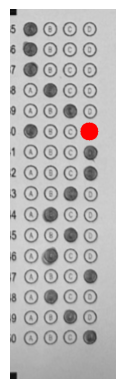

white_pixel_count 97920
--------------------------------------------------


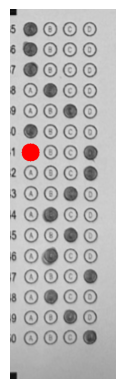

white_pixel_count 93840
--------------------------------------------------


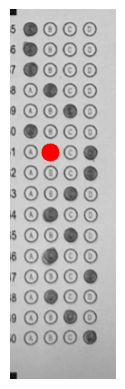

white_pixel_count 97665
--------------------------------------------------


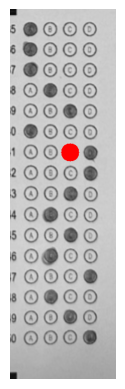

white_pixel_count 89505
--------------------------------------------------


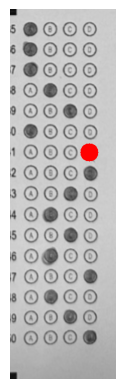

white_pixel_count 130560
--------------------------------------------------


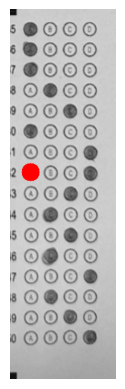

white_pixel_count 96135
--------------------------------------------------


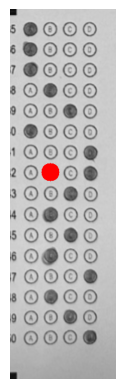

white_pixel_count 100725
--------------------------------------------------


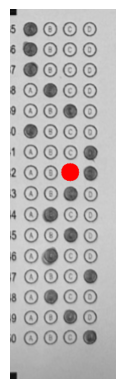

white_pixel_count 86700
--------------------------------------------------


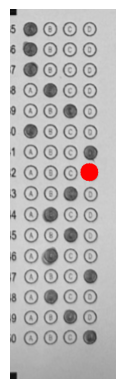

white_pixel_count 128520
--------------------------------------------------


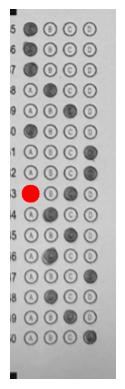

white_pixel_count 95115
--------------------------------------------------


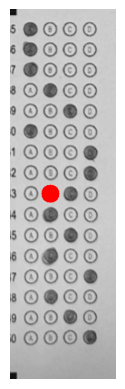

white_pixel_count 90525
--------------------------------------------------


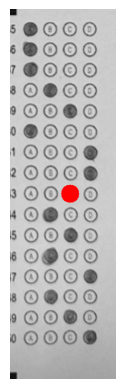

white_pixel_count 130560
--------------------------------------------------


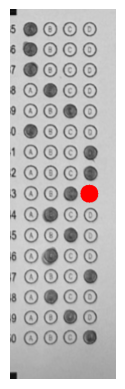

white_pixel_count 95370
--------------------------------------------------


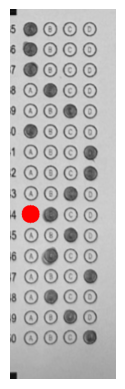

white_pixel_count 90525
--------------------------------------------------


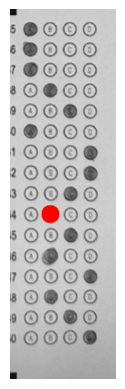

white_pixel_count 142800
--------------------------------------------------


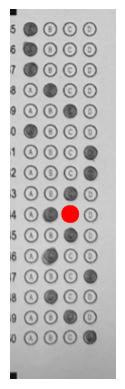

white_pixel_count 79815
--------------------------------------------------


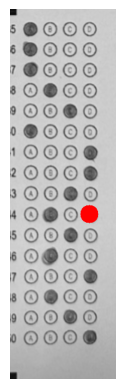

white_pixel_count 99195
--------------------------------------------------


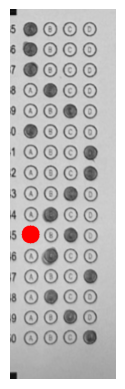

white_pixel_count 91290
--------------------------------------------------


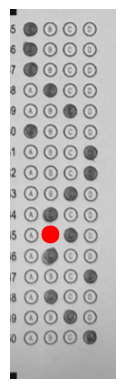

white_pixel_count 84660
--------------------------------------------------


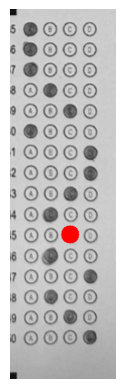

white_pixel_count 127755
--------------------------------------------------


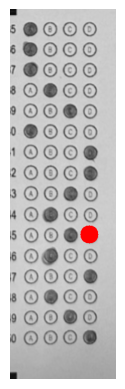

white_pixel_count 94095
--------------------------------------------------


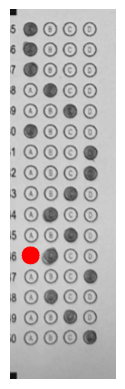

white_pixel_count 86955
--------------------------------------------------


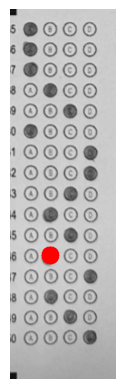

white_pixel_count 154530
--------------------------------------------------


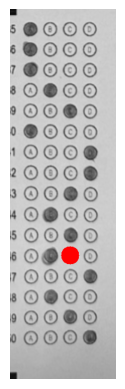

white_pixel_count 82620
--------------------------------------------------


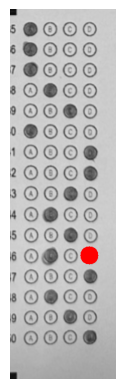

white_pixel_count 96900
--------------------------------------------------


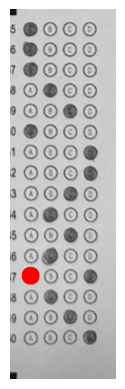

white_pixel_count 91545
--------------------------------------------------


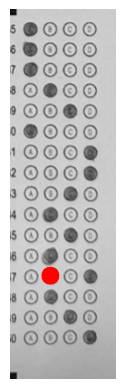

white_pixel_count 85170
--------------------------------------------------


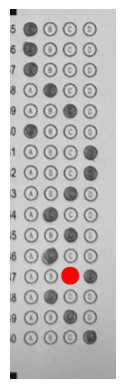

white_pixel_count 85935
--------------------------------------------------


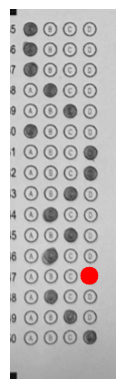

white_pixel_count 126990
--------------------------------------------------


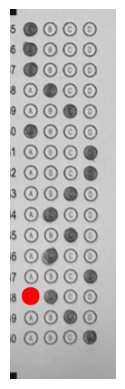

white_pixel_count 88995
--------------------------------------------------


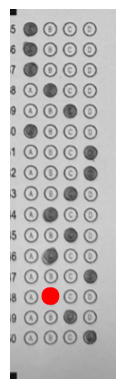

white_pixel_count 126990
--------------------------------------------------


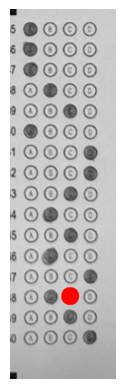

white_pixel_count 84405
--------------------------------------------------


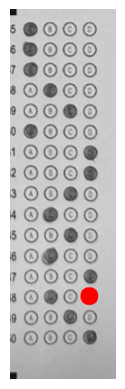

white_pixel_count 96390
--------------------------------------------------


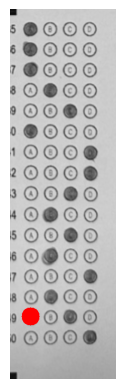

white_pixel_count 91545
--------------------------------------------------


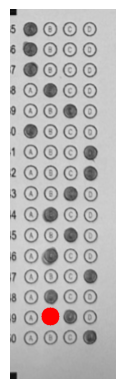

white_pixel_count 85425
--------------------------------------------------


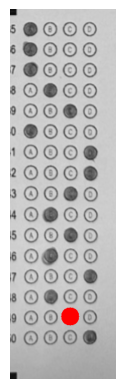

white_pixel_count 124695
--------------------------------------------------


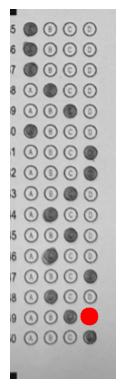

white_pixel_count 92565
--------------------------------------------------


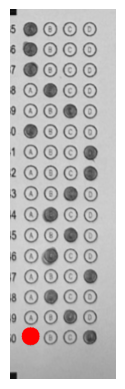

white_pixel_count 91035
--------------------------------------------------


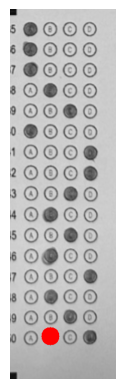

white_pixel_count 94605
--------------------------------------------------


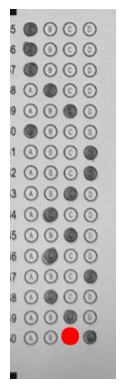

white_pixel_count 89250
--------------------------------------------------


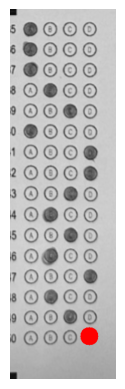

white_pixel_count 127500
--------------------------------------------------


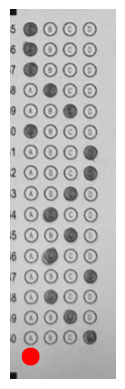

white_pixel_count 0
--------------------------------------------------


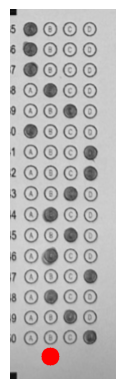

white_pixel_count 0
--------------------------------------------------


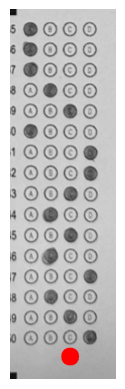

white_pixel_count 0
--------------------------------------------------


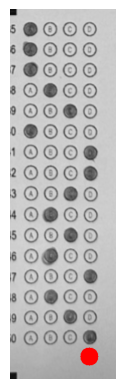

white_pixel_count 0
--------------------------------------------------


In [15]:
test_img = answers[2]
test_img = cv.cvtColor(test_img,cv.COLOR_GRAY2BGR)
test_detect = preprocess_detect(answers[2])

white_pixel_counts = []
min_white_pixels = 100
radius = 15
rows = len(y_group)
cols = len(x_group)

imshowRGB(test_detect)
plt.show()

for y in y_group:
    for x in x_group:
        center = (x,y)
        roi = test_detect[center[1]-radius:center[1]+radius, center[0]-radius:center[0]+radius]
        # Count the white pixels in the roi
        count = np.sum(roi)
        white_pixel_counts.append(count)

        imshowRGB(cv.circle(test_img.copy(), [x,y], radius=15, color=(0, 0, 255), thickness=-1))
        plt.show()
        print("white_pixel_count", count)
        print("-"*50)
white_pixel_counts = np.asarray(white_pixel_counts).reshape((rows,cols))

In [16]:
white_pixel_counts

array([[128775,  91545,  96135, 100215],
       [130050,  90525,  92055,  98175],
       [130560,  84915,  93330,  97410],
       [ 87210, 125970,  88740,  96135],
       [ 88485,  87465, 127245,  98175],
       [128520,  92820,  88740,  97920],
       [ 93840,  97665,  89505, 130560],
       [ 96135, 100725,  86700, 128520],
       [ 95115,  90525, 130560,  95370],
       [ 90525, 142800,  79815,  99195],
       [ 91290,  84660, 127755,  94095],
       [ 86955, 154530,  82620,  96900],
       [ 91545,  85170,  85935, 126990],
       [ 88995, 126990,  84405,  96390],
       [ 91545,  85425, 124695,  92565],
       [ 91035,  94605,  89250, 127500],
       [     0,      0,      0,      0]], dtype=uint32)

In [17]:
white_pixel_counts-np.average(white_pixel_counts)

array([[ 3.332625e+04, -3.903750e+03,  6.862500e+02,  4.766250e+03],
       [ 3.460125e+04, -4.923750e+03, -3.393750e+03,  2.726250e+03],
       [ 3.511125e+04, -1.053375e+04, -2.118750e+03,  1.961250e+03],
       [-8.238750e+03,  3.052125e+04, -6.708750e+03,  6.862500e+02],
       [-6.963750e+03, -7.983750e+03,  3.179625e+04,  2.726250e+03],
       [ 3.307125e+04, -2.628750e+03, -6.708750e+03,  2.471250e+03],
       [-1.608750e+03,  2.216250e+03, -5.943750e+03,  3.511125e+04],
       [ 6.862500e+02,  5.276250e+03, -8.748750e+03,  3.307125e+04],
       [-3.337500e+02, -4.923750e+03,  3.511125e+04, -7.875000e+01],
       [-4.923750e+03,  4.735125e+04, -1.563375e+04,  3.746250e+03],
       [-4.158750e+03, -1.078875e+04,  3.230625e+04, -1.353750e+03],
       [-8.493750e+03,  5.908125e+04, -1.282875e+04,  1.451250e+03],
       [-3.903750e+03, -1.027875e+04, -9.513750e+03,  3.154125e+04],
       [-6.453750e+03,  3.154125e+04, -1.104375e+04,  9.412500e+02],
       [-3.903750e+03, -1.002375e+

In [18]:
white_pixel_counts-np.average(white_pixel_counts) >= 10000

array([[ True, False, False, False],
       [ True, False, False, False],
       [ True, False, False, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [ True, False, False, False],
       [False, False, False,  True],
       [False, False, False,  True],
       [False, False,  True, False],
       [False,  True, False, False],
       [False, False,  True, False],
       [False,  True, False, False],
       [False, False, False,  True],
       [False,  True, False, False],
       [False, False,  True, False],
       [False, False, False,  True],
       [False, False, False, False]])

In [19]:
ans = matrix2ans(white_pixel_counts-np.average(white_pixel_counts), threshold = 10000 , start_index=35)
ans

{35: 'A',
 36: 'A',
 37: 'A',
 38: 'B',
 39: 'C',
 40: 'A',
 41: 'D',
 42: 'D',
 43: 'C',
 44: 'B',
 45: 'C',
 46: 'B',
 47: 'D',
 48: 'B',
 49: 'C',
 50: 'D',
 51: ''}

In [20]:
test_answers = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'A', 6: 'B', 7: 'C', 8: 'D', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'A', 18: 'B', 19: 'C', 20: 'D', 21: 'A', 22: 'B', 23: 'C', 24: 'D', 25: 'A', 26: 'B', 27: 'C', 28: 'D', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'A', 34: 'B', 35: 'C', 36: 'D', 37: 'A', 38: 'B', 39: 'C', 40: 'D', 41: 'A', 42: 'B', 43: 'C', 44: 'D', 45: 'A', 46: 'B', 47: 'C', 48: 'D', 49: 'A', 50: 'B'}
# test_answers = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'A', 6: 'B', 7: 'C', 8: 'D', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'A'}

In [21]:
def get_correct_ans(user_answers, test_answers):
    """
        Tính kết quả đúng.
        Trả về dictionary {vị trí câu: kết quả}.

        user_answers: Câu trả lời cần kiểm tra.
        test_answers: Câu trả lời đúng.
    """
    correct_answers = {k: test_answers[k] for k in test_answers if k in user_answers and test_answers[k] == user_answers[k]}
    return correct_answers

In [22]:
get_correct_ans(ans, test_answers)

{37: 'A', 38: 'B', 39: 'C', 43: 'C', 46: 'B'}

In [24]:
test_answers = {1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'A', 6: 'B', 7: 'C', 8: 'D', 9: 'A', 10: 'B', 11: 'C', 12: 'D', 13: 'A', 14: 'B', 15: 'C', 16: 'D', 17: 'A',
                18: 'B', 19: 'C', 20: 'D', 21: 'A', 22: 'B', 23: 'C', 24: 'D', 25: 'A', 26: 'B', 27: 'C', 28: 'D', 29: 'A', 30: 'B', 31: 'C', 32: 'D', 33: 'A', 34: 'B',
                35: 'C', 36: 'D', 37: 'A', 38: 'B', 39: 'C', 40: 'D', 41: 'A', 42: 'B', 43: 'C', 44: 'D', 45: 'A', 46: 'B', 47: 'C,D', 48: 'A', 49: 'B', 50: 'C'}

In [27]:
user_answers = {1: 'B', 2: 'A', 3: 'D', 4: 'C', 5: 'B', 6: 'A', 7: 'C', 8: 'D', 9: 'A', 10: 'C', 11: 'B', 12: 'D', 13: 'A', 14: 'D', 15: 'C', 16: 'B', 17: 'C',
                18: 'D', 19: 'A', 20: 'B', 21: 'D', 22: 'C', 23: 'A', 24: 'B', 25: 'C', 26: 'D', 27: 'A', 28: 'B', 29: 'C', 30: 'D', 31: 'A', 32: 'B', 33: 'C',
                34: 'D', 35: 'A', 36: 'B', 37: 'D', 38: 'C', 39: 'A', 40: 'B', 41: 'C', 42: 'D', 43: 'A', 44: 'B', 45: 'D', 46: 'C', 47: 'C,D', 48: 'D', 49: 'B', 50: 'C'}


In [365]:
test_answers[1]

'A'

In [366]:
_ = 'A, B'
test_ = _.replace(' ', '').split(",")

In [367]:
len(_)

4

In [368]:
[encode_ABCD(ans) for ans in test_ ]

[[1], [2]]

In [28]:
def encode_ABCD(input_):
    if len(input_) == 1:
        if input_ == 'A': return [1] # Trả về list để đồng nhất với TH len(input_)!=1
        elif input_ == 'B': return [2]
        elif input_ == 'C': return [3]
        elif input_ == 'D': return [4]
        else: raise Exception("Chỉ nhận ABCD ở hàm encode_ABCD!")
    elif len(input_) > 1:
        input_ = input_.replace(' ', '').split(",")
        return [encode_ABCD(ans)[0] for ans in input_ ]
    else:
        raise Exception("Chỉ nhận ABCD ở hàm encode_ABCD! Nhận được input rỗng.")

In [25]:
result_img = de_warp_color.copy()

In [30]:
sorted_lower_anchor

array([[[ 110,  620],
        [ 109, 1237]],

       [[ 309,  618],
        [ 308, 1232]],

       [[ 504,  618],
        [ 504, 1236]]])

In [31]:
round((round((sorted_lower_anchor[2][0][0]-sorted_lower_anchor[1][0][0])/6)+
       round((sorted_lower_anchor[2][1][0]-sorted_lower_anchor[1][1][0])/6))/2)

32

In [373]:
user_answers[1]

'B'

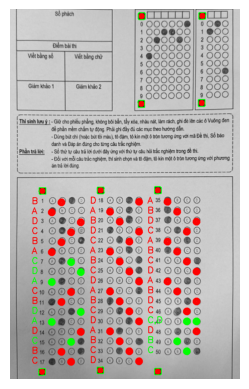

In [32]:
result_img = de_warp_color.copy()
show_true_answer = False
for idx, ans in test_answers.items():
    #Phân Group
    if idx < 18: 
        group = 0
        row = idx
    elif idx < 35: 
        group = 1
        row = idx-17
    else: 
        group = 2
        row = idx-34
    if user_answers[idx] == ans:# Nếu trả lời đúng
        encoded_ABCD = encode_ABCD(ans)
        cols = encoded_ABCD #cols vì hàm encode_ABCD có thể trả ra nhiều hơn một số nếu user khoanh 2 đáp án cùng lúc.
        text = ans
        main_color = (0, 255, 0) #green
    else:# Trả lời sai
        encoded_ABCD = encode_ABCD(user_answers[idx])
        cols = encoded_ABCD
        text = user_answers[idx]
        main_color = (0, 0, 255) #red
        # Hiển thị đáp án đúng
        if show_true_answer == True:
            true_col =  encode_ABCD(ans)
            true_x_offset_circle = round(((sorted_lower_anchor[1][0][0]-sorted_lower_anchor[0][0][0])/6+
                                 (sorted_lower_anchor[1][1][0]-sorted_lower_anchor[0][1][0])/6)/2) * true_col  
            cv.circle(result_img,
                    ((sorted_lower_anchor[group][0][0]+sorted_lower_anchor[group][1][0])//2 + true_x_offset_circle, 
                    sorted_lower_anchor[group][0][1]+round(abs(sorted_lower_anchor[group][0][1]-sorted_lower_anchor[group][1][1])/18.2)*row+5),
                    radius=7,
                    color=(0, 255, 0), 
                    thickness=12)
    for col in cols:
        x_offset_text = -35
        x_offset_circle = round(((sorted_lower_anchor[1][0][0]-sorted_lower_anchor[0][0][0])/6+
                                 (sorted_lower_anchor[1][1][0]-sorted_lower_anchor[0][1][0])/6)/2) * col  
        cv.putText(result_img, text,
                    org=((sorted_lower_anchor[group][0][0]+sorted_lower_anchor[group][1][0])//2 + x_offset_text, 
                    sorted_lower_anchor[group][0][1]+round(abs(sorted_lower_anchor[group][0][1]-sorted_lower_anchor[group][1][1])/18)*row+10),
                    color=main_color, 
                    thickness=2,
                    fontScale=1,
                    fontFace=cv.LINE_AA)
        cv.circle(result_img,
                    ((sorted_lower_anchor[group][0][0]+sorted_lower_anchor[group][1][0])//2 + x_offset_circle, 
                    sorted_lower_anchor[group][0][1]+round(abs(sorted_lower_anchor[group][0][1]-sorted_lower_anchor[group][1][1])/18.2)*row+5),
                    radius=7,
                    color=main_color, 
                    thickness=12)
imshowRGB(result_img)